In [1]:
import pandas as pd
import math
import os
import os.path
import time
from bitmex import bitmex
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook


In [2]:
bitmex_api_key = os['APIKEY']
bitmex_api_secret = os['SECRETAPIKEY']

In [3]:
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 750
bitmex_client = bitmex(test=False, api_key=bitmex_api_key, api_secret=bitmex_api_secret)

/Users/ar9av/Work/NER-NEL/glot/lib/python3.7/site-packages/swagger_spec_validator/validator20.py:53: SwaggerValidationWarning: Found "$ref: #/definitions/UserPreferences" with siblings that will be overwritten. See https://stackoverflow.com/a/48114924 for more information. (path #/definitions/User/properties/preferences)
  ref_dict['$ref'], '/'.join(path),


In [4]:
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "bitmex": old = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=False).result()[0][0]['timestamp']
    if source == "bitmex": new = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=1, reverse=True).result()[0][0]['timestamp']
    return old, new

In [5]:
def get_all_bitmex(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "bitmex")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    rounds = math.ceil(available_data / batch_size)
    if rounds > 0:
        print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data in %d rounds.' % (delta_min, symbol, available_data, kline_size, rounds))
        for round_num in tqdm_notebook(range(rounds)):
            time.sleep(1)
            new_time = (oldest_point + timedelta(minutes = round_num * batch_size * binsizes[kline_size]))
            data = bitmex_client.Trade.Trade_getBucketed(symbol=symbol, binSize=kline_size, count=batch_size, startTime = new_time).result()[0]
            temp_df = pd.DataFrame(data)
            data_df = data_df.append(temp_df)
    data_df.set_index('timestamp', inplace=True)
    if save and rounds > 0: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

In [7]:
get_all_bitmex("ETHUSD", "5m", save = True)

/Users/ar9av/Work/NER-NEL/glot/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()



All caught up..!


,symbol,open,high,low,close,trades,volume,vwap,lastSize,turnover,homeNotional,foreignNotional
timestamp,,,,,,,,,,,,
2018-08-02 09:05:00+00:00,ETHUSD,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0.000000,0.000000e+00
2018-08-02 09:10:00+00:00,ETHUSD,400.0,435.50,400.00,435.50,3,3,418.50,1.0,125550,0.022901,9.583905e+00
2018-08-02 09:15:00+00:00,ETHUSD,435.5,425.00,406.05,416.00,25,1944,420.47,89.0,81738315,14.840168,6.239761e+03
2018-08-02 09:20:00+00:00,ETHUSD,416.0,422.90,418.00,422.40,32,6548,422.44,50.0,276608380,49.996751,2.112022e+04
2018-08-02 09:25:00+00:00,ETHUSD,422.4,422.40,421.30,421.80,10,1071,421.66,10.0,45159000,8.174452,3.446780e+03
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-06 07:55:00+00:00,ETHUSD,2696.0,2697.35,2692.50,2693.30,43,2053,2694.60,1.0,553201005,74.253212,2.000826e+05
2021-06-06 08:00:00+00:00,ETHUSD,2693.3,2697.15,2692.40,2692.40,57,2828,2694.21,6.0,761921810,102.297046,2.756095e+05
2021-06-06 08:05:00+00:00,ETHUSD,2692.4,2704.75,2694.00,2700.90,211,10346,2701.55,10.0,2795020880,374.351287,1.011328e+06


In [143]:
df = pd.read_csv('ETHUSD-5m-data.csv')

In [144]:
df

,timestamp,symbol,open,high,low,close,trades,volume,vwap,lastSize,turnover,homeNotional,foreignNotional
0,2018-08-02 09:05:00+00:00,ETHUSD,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0,0.000000,0.000000e+00
1,2018-08-02 09:10:00+00:00,ETHUSD,400.0,435.50,400.00,435.50,3,3,418.50,1.0,125550,0.022901,9.583905e+00
2,2018-08-02 09:15:00+00:00,ETHUSD,435.5,425.00,406.05,416.00,25,1944,420.47,89.0,81738315,14.840168,6.239761e+03
3,2018-08-02 09:20:00+00:00,ETHUSD,416.0,422.90,418.00,422.40,32,6548,422.44,50.0,276608380,49.996751,2.112022e+04
4,2018-08-02 09:25:00+00:00,ETHUSD,422.4,422.40,421.30,421.80,10,1071,421.66,10.0,45159000,8.174452,3.446780e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
299218,2021-06-06 07:55:00+00:00,ETHUSD,2696.0,2697.35,2692.50,2693.30,43,2053,2694.60,1.0,553201005,74.253212,2.000826e+05
299219,2021-06-06 08:00:00+00:00,ETHUSD,2693.3,2697.15,2692.40,2692.40,57,2828,2694.21,6.0,761921810,102.297046,2.756095e+05
299220,2021-06-06 08:05:00+00:00,ETHUSD,2692.4,2704.75,2694.00,2700.90,211,10346,2701.55,10.0,2795020880,374.351287,1.011328e+06
299221,2021-06-06 08:10:00+00:00,ETHUSD,2700.9,2713.90,2700.05,2713.90,227,12145,2708.44,717.0,3289388630,439.151216,1.189410e+06


In [145]:
def get_day(date):
    year, month, day  = (int(x) for x in (date.split('T')[0]).split('-')) 
    ans = datetime.date(year, month, day)
    return ans.strftime("%A")

In [146]:
import datetime

In [147]:
from dateutil import parser
df['timestamp'] = df.timestamp.apply(lambda x: parser.parse(x))
df = df.set_index('timestamp')
df2 = df.resample('D').mean()
df2['day'] = [get_day(str(x)) for x in df2.index.values]

In [148]:
df2

,open,high,low,close,trades,volume,vwap,lastSize,turnover,homeNotional,foreignNotional,day
timestamp,,,,,,,,,,,,
2018-08-02 00:00:00+00:00,412.620787,413.387079,411.802247,412.685393,59.743017,24658.581006,412.648146,261.848315,1.015947e+09,186.074886,7.666548e+04,Thursday
2018-08-03 00:00:00+00:00,410.011632,410.465278,409.571354,410.033333,36.802083,28038.663194,410.021007,787.635417,1.153457e+09,207.935939,8.554728e+04,Friday
2018-08-04 00:00:00+00:00,412.340451,412.620139,411.994271,412.302951,24.666667,21425.378472,412.375211,1032.830986,8.816876e+08,155.381901,6.396130e+04,Saturday
2018-08-05 00:00:00+00:00,406.755903,407.026389,406.527431,406.765104,21.892361,14528.493056,406.789443,536.536585,5.914288e+08,101.686554,4.139651e+04,Sunday
2018-08-06 00:00:00+00:00,407.319271,407.568750,407.042014,407.302951,32.006944,21391.305556,407.302404,601.226481,8.691619e+08,149.127434,6.059995e+04,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-02 00:00:00+00:00,2696.631771,2702.812153,2691.294792,2696.935243,265.079861,11182.354167,2697.025868,37.802083,3.028143e+09,417.797490,1.131664e+06,Wednesday
2021-06-03 00:00:00+00:00,2798.464757,2804.509201,2792.420486,2798.936285,283.527778,12478.638889,2798.491840,34.892361,3.495440e+09,481.449617,1.348993e+06,Thursday
2021-06-04 00:00:00+00:00,2682.811632,2689.112674,2674.943403,2682.247917,332.822917,17150.788194,2681.858056,34.131944,4.584788e+09,635.533748,1.699640e+06,Friday


In [149]:
subset = df2[df2.day.isin(['Sunday', 'Thursday'])]

In [150]:
subset2 = subset.drop('day', axis = 1).iloc[::-1]

In [151]:
sub2 = subset2

In [152]:
sub2['day'] = [get_day(str(x)) for x in sub2.index.values]

In [153]:
sub2['avg'] = (sub2.high + sub2.low)/2

In [154]:
sub2

,open,high,low,close,trades,volume,vwap,lastSize,turnover,homeNotional,foreignNotional,day,avg
timestamp,,,,,,,,,,,,,
2021-06-06 00:00:00+00:00,2673.192500,2678.942000,2669.373000,2674.084000,188.910000,8484.760000,2674.373000,37.020000,2.269979e+09,305.501911,8.173637e+05,Sunday,2674.157500
2021-06-03 00:00:00+00:00,2798.464757,2804.509201,2792.420486,2798.936285,283.527778,12478.638889,2798.491840,34.892361,3.495440e+09,481.449617,1.348993e+06,Thursday,2798.464844
2021-05-30 00:00:00+00:00,2382.269965,2389.786111,2375.666493,2382.657292,270.847222,10674.944444,2382.827292,25.614583,2.537012e+09,378.008079,8.989302e+05,Sunday,2382.726302
2021-05-27 00:00:00+00:00,2771.015972,2779.500868,2762.400000,2770.571181,273.597222,11334.878472,2770.948681,35.840278,3.133854e+09,438.671637,1.213291e+06,Thursday,2770.950434
2021-05-23 00:00:00+00:00,2107.311458,2121.617882,2092.647049,2106.677257,516.822917,31120.715278,2106.923090,43.875000,6.287584e+09,1061.080376,2.149423e+06,Sunday,2107.132465
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-16 00:00:00+00:00,287.842361,288.486806,287.226562,287.861632,150.767361,227180.517361,287.865278,935.625000,6.544476e+09,1441.338624,4.152814e+05,Thursday,287.856684
2018-08-12 00:00:00+00:00,321.497222,321.994792,321.066667,321.493750,59.152778,60652.888889,321.538924,744.173611,1.947856e+09,381.761247,1.226078e+05,Sunday,321.530729
2018-08-09 00:00:00+00:00,361.161285,361.635590,360.769965,361.194792,59.885417,41638.465278,361.222326,702.479167,1.504933e+09,266.473765,9.632806e+04,Thursday,361.202778


In [155]:
sub2.head(40)

,open,high,low,close,trades,volume,vwap,lastSize,turnover,homeNotional,foreignNotional,day,avg
timestamp,,,,,,,,,,,,,
2021-06-06 00:00:00+00:00,2673.192500,2678.942000,2669.373000,2674.084000,188.910000,8484.760000,2674.373000,37.020000,2.269979e+09,305.501911,8.173637e+05,Sunday,2674.157500
2021-06-03 00:00:00+00:00,2798.464757,2804.509201,2792.420486,2798.936285,283.527778,12478.638889,2798.491840,34.892361,3.495440e+09,481.449617,1.348993e+06,Thursday,2798.464844
2021-05-30 00:00:00+00:00,2382.269965,2389.786111,2375.666493,2382.657292,270.847222,10674.944444,2382.827292,25.614583,2.537012e+09,378.008079,8.989302e+05,Sunday,2382.726302
2021-05-27 00:00:00+00:00,2771.015972,2779.500868,2762.400000,2770.571181,273.597222,11334.878472,2770.948681,35.840278,3.133854e+09,438.671637,1.213291e+06,Thursday,2770.950434
2021-05-23 00:00:00+00:00,2107.311458,2121.617882,2092.647049,2106.677257,516.822917,31120.715278,2106.923090,43.875000,6.287584e+09,1061.080376,2.149423e+06,Sunday,2107.132465
2021-05-20 00:00:00+00:00,2695.115625,2714.867187,2676.842188,2696.140104,502.621528,25410.423611,2695.752118,45.562500,6.785174e+09,1004.807986,2.690911e+06,Thursday,2695.854688
2021-05-16 00:00:00+00:00,3702.984896,3715.526562,3691.209549,3702.744618,456.913194,21155.229167,3703.530729,34.802083,7.619512e+09,990.950554,3.573176e+06,Sunday,3703.368056
2021-05-13 00:00:00+00:00,3824.648437,3842.596701,3807.167014,3823.981250,738.763889,36625.475694,3824.537527,38.812721,1.385375e+10,1808.621153,6.844321e+06,Thursday,3824.881858
2021-05-09 00:00:00+00:00,3896.291319,3904.873958,3887.390278,3896.338715,357.364583,14859.701389,3896.188958,30.298611,5.766311e+09,859.981289,3.337484e+06,Sunday,3896.132118


In [157]:
(2674.157500 - 1253.397569)/1253.397569

1.1335269559630046

<Figure size 1440x720 with 0 Axes>

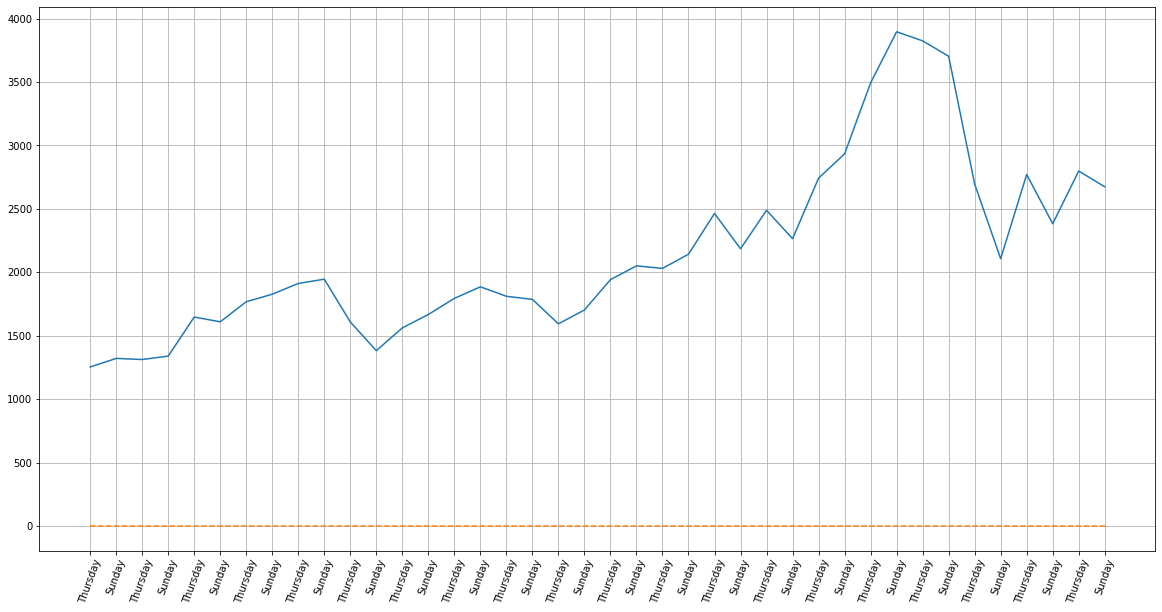

In [156]:

from matplotlib import pyplot as plt
plt.figure(figsize=(20, 10))
n = 40
xs = sub2.head(n).iloc[::-1]
proj = xs.day.values
proj_x = range(len(proj))
fig = plt.figure(figsize=(20, 10))
plt.plot(proj_x, xs.avg.values)

plt.plot(proj_x, [0]*len(xs), r'--') 
plt.xticks(proj_x, proj)
degrees = 70
plt.grid()
plt.xticks(rotation=degrees)
plt.savefig('plots/eth-thursday-sunday-strat-values.png')
